
##Setup

You will need to make a copy of this Colab notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.


In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

#! ls /content
#!ls /content/gdrive/My\ Drive

In [2]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

# Need to download the Omniglot dataset -- DON'T MODIFY THIS CELL
if not os.path.isdir('./omniglot_resized'):
    gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
                                        dest_path='./omniglot_resized.zip',
                                        unzip=True)
    
assert os.path.isdir('./omniglot_resized')
print('done')

Unzipping...Done.
done


In [3]:
"""Data loading scripts"""
## NOTE: You do not need to modify this block but you will need to use it.
import numpy as np
import os
import random
import tensorflow as tf
from scipy import misc
import imageio

def get_images(paths, labels, n_samples=None, shuffle=True):
  """
  Takes a set of character folders and labels and returns paths to image files
  paired with labels.
  Args:
    paths: A list of character folders
    labels: List or numpy array of same length as paths
    n_samples: Number of images to retrieve per character
  Returns:
    List of (label, image_path) tuples
  """
  if n_samples is not None:
    sampler = lambda x: random.sample(x, n_samples)
  else:
    sampler = lambda x: x
  images_labels = [(i, os.path.join(path, image))
           for i, path in zip(labels, paths)
           for image in sampler(os.listdir(path))]
  if shuffle:
    random.shuffle(images_labels)
  return images_labels


def image_file_to_array(filename, dim_input):
  """
  Takes an image path and returns numpy array
  Args:
    filename: Image filename
    dim_input: Flattened shape of image
  Returns:
    1 channel image
  """
  image = imageio.imread(filename)
  image = image.reshape([dim_input])
  image = image.astype(np.float32) / 255.0
  image = 1.0 - image
  return image


class DataGenerator(object):
  """
  Data Generator capable of generating batches of Omniglot data.
  A "class" is considered a class of omniglot digits.
  """

  def __init__(self, num_classes, num_samples_per_class,train_type ='memorization', config={}):
    """
    Args:
      num_classes: Number of classes for classification (K-way)
      num_samples_per_class: num samples to generate per class in one batch
      num_meta_test_classes: Number of classes for classification (K-way) at meta-test time
      num_meta_test_samples_per_class: num samples to generate per class in one batch at meta-test time
      batch_size: size of meta batch size (e.g. number of functions)
    """
    self.num_samples_per_class = num_samples_per_class
    self.num_classes = num_classes
    self.train_type = train_type

    data_folder = config.get('data_folder', './omniglot_resized')
    self.img_size = config.get('img_size', (28, 28))

    self.dim_input = np.prod(self.img_size)
    self.dim_output = self.num_classes

    character_folders = [os.path.join(data_folder, family, character)
               for family in os.listdir(data_folder)
               if os.path.isdir(os.path.join(data_folder, family))
               for character in os.listdir(os.path.join(data_folder, family))
               if os.path.isdir(os.path.join(data_folder, family, character))]

    random.seed(123)
    #random.shuffle(character_folders)
    num_val = 400
    num_train = 1200
    self.metatrain_character_folders = character_folders[: num_train]
    self.metaval_character_folders = character_folders[
      num_train:num_train + num_val]
    self.metatest_character_folders = character_folders[
      num_train + num_val:]
    
    print("Number of training examples. : ",len(self.metatrain_character_folders))
    print("Number of validation examples: ",len(self.metaval_character_folders))
    print("Number of test examples      : ",len(self.metatest_character_folders))
    print("Training Type: ",self.train_type)

    if self.train_type == 'memorization':
      self.metatrain_label = [i%self.num_classes for i in range(len(self.metatrain_character_folders))]
      self.metaval_label = [i%self.num_classes for i in range(len(self.metaval_character_folders))]
      self.metatest_label = [i%self.num_classes for i in range(len(self.metatest_character_folders))]

  def sample_batch(self, batch_type, batch_size, shuffle=True, swap=False):
    """
    Samples a batch for training, validation, or testing
    Args:
      batch_type: meta_train/meta_val/meta_test
      shuffle: randomly shuffle classes or not
      swap: swap number of classes (N) and number of samples per class (K) or not
    Returns:
      A a tuple of (1) Image batch and (2) Label batch where
      image batch has shape [B, N, K, 784] and label batch has shape [B, N, K, N] if swap is False
      where B is batch size, K is number of samples per class, N is number of classes
    """
    if batch_type == "meta_train":
      folders = self.metatrain_character_folders
      num_classes = self.num_classes
      num_samples_per_class = self.num_samples_per_class
      if self.train_type == 'memorization':
        class_label = self.metatrain_label
    elif batch_type == "meta_val":
      folders = self.metaval_character_folders
      num_classes = self.num_classes
      num_samples_per_class = self.num_samples_per_class
      if self.train_type == 'memorization':
        class_label = self.metaval_label
    elif batch_type == "meta_test":
      folders = self.metatest_character_folders
      num_classes = self.num_classes
      num_samples_per_class = self.num_samples_per_class
      if self.train_type == 'memorization':
        class_label = self.metatest_label
    else:
      raise Exception('undefied data type')

    all_image_batches, all_label_batches = [], []
    total_sample = [val for val in range(len(folders))]
    for i in range(batch_size):
      data_list = random.sample(total_sample, num_classes)
      #print("data_list: ",data_list)
      sampled_character_folders = [folders[n_val] for n_val in data_list]
      if self.train_type == 'memorization':
        sampled_label = [class_label[n_val] for n_val in data_list]
      else:
        sampled_label = [n_val for n_val in range(num_classes)]
      #print("sampled_label:",sampled_label)
      #print("sampled_character_folders: ",sampled_character_folders)
      labels_and_images = get_images(sampled_character_folders,sampled_label,n_samples=num_samples_per_class,shuffle=False)
      labels = [li[0] for li in labels_and_images]
      images = [image_file_to_array(
        li[1], self.dim_input) for li in labels_and_images]
      images = np.stack(images)
      labels = np.array(labels).astype(np.int32)
      labels = np.reshape(
        labels, (num_classes, num_samples_per_class))
      labels = np.eye(num_classes, dtype=np.float32)[labels]
      images = np.reshape(
        images, (num_classes, num_samples_per_class, -1))

      batch = np.concatenate([labels, images], 2)
      if shuffle:
        for p in range(num_samples_per_class):
          np.random.shuffle(batch[:, p])

      labels = batch[:, :, :num_classes]
      images = batch[:, :, num_classes:]

      if swap:
        labels = np.swapaxes(labels, 0, 1)
        images = np.swapaxes(images, 0, 1)

      all_image_batches.append(images)
      all_label_batches.append(labels)
    all_image_batches = np.stack(all_image_batches)
    all_label_batches = np.stack(all_label_batches)
    return all_image_batches.astype(np.float32), all_label_batches.astype(np.float32)

In [4]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers


class MANN_UPDATE(tf.keras.Model):

    def __init__(self, num_classes, samples_per_class):
        super(MANN_UPDATE, self).__init__()
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class
        self.conv1 =  tf.keras.layers.Conv2D(8, 3, padding='same', activation=None,data_format="channels_last")
        self.maxpool_1 = tf.keras.layers.MaxPooling2D(pool_size=2,data_format="channels_last")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 =  tf.keras.layers.Conv2D(16, 3, padding='same', activation=None,data_format="channels_last")
        self.maxpool_2 = tf.keras.layers.MaxPooling2D(pool_size=2,data_format="channels_last")
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.flatten = tf.keras.layers.Flatten(data_format="channels_last")
        self.layer1 = tf.keras.layers.LSTM(128, return_sequences=True)
        self.layer2 = tf.keras.layers.LSTM(num_classes, return_sequences=True)

    @tf.function
    def call(self, input_images, input_labels,training):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels: [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        #############################
        #### YOUR CODE GOES HERE ####
        #print("input_images,",input_images.shape,input_labels.shape)
        x = tf.reshape(input_images, [input_images.shape[0]*self.num_classes*self.samples_per_class,-1])
        x = tf.reshape(x, [x.shape[0],28,28,1])
        # do a convoultion on the image
        #conv1
        x_conv1 = self.conv1(x)
        x_conv1 = self.bn1(x_conv1, training=training)
        x_conv1 = tf.nn.relu(x_conv1)
        x_maxpool_1 = self.maxpool_1(x_conv1)
        #conv2
        x_conv2 = self.conv2(x_maxpool_1)
        x_conv2 = self.bn2(x_conv2, training=training)
        x_conv2 = tf.nn.relu(x_conv2)
        x_maxpool_2 = self.maxpool_2(x_conv2)
        #flatten the feature
        x_flatten = self.flatten(x_maxpool_2)
        x_feature = tf.reshape(x_flatten, [input_images.shape[0],self.samples_per_class,self.num_classes,-1])
        #mask labels of last N images
        mask_vector = tf.zeros([input_labels.shape[0],1,self.num_classes,self.num_classes],dtype=tf.dtypes.float32)
        masked_label = tf.concat([input_labels[:,:self.samples_per_class-1,:,:], mask_vector], 1)
        meta_input = tf.concat([x_feature, masked_label], 3)
        meta_input_flatten = tf.reshape(meta_input, [input_images.shape[0],self.num_classes*self.samples_per_class,-1])
        # LSTM (MANN block) 
        hx = self.layer1(meta_input_flatten)
        logit = self.layer2(hx)
        out = tf.reshape(logit, [input_images.shape[0],self.samples_per_class,self.num_classes,-1])
        #############################
        return out,hx,meta_input_flatten

    def loss_function(self, preds, labels):
        """
        Computes MANN loss
        Args:
            preds: [B, K+1, N, N] network output
            labels: [B, K+1, N, N] labels
        Returns:
            scalar loss
        """
        #############################
        loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        loss = loss_object(labels[:,self.samples_per_class-1:,:,:],preds[:,self.samples_per_class-1:,:,:])
        return loss
        #############################


@tf.function
def train_step_update(images, labels, model, optim, eval=False,training=False):
    with tf.GradientTape() as tape:
        predictions,hx,latent_x = model(images, labels,training=training)
        h_summary = hx[:,4,:]
        x_latent = latent_x[:,:5,:]
        z_task = tf.reduce_mean(x_latent,axis=1)
        #print(hx.shape,latent_x.shape)
        #print("h_summary:",h_summary.shape,x_latent.shape,z_task.shape)
        #compute meta_reg value
        batch_dim = hx.shape[0]
        count =0
        if not eval:
          for i in range(0,batch_dim-1):
            for j in range(i+1,batch_dim):
              count+=1
              #zz = tf.stop_gradient(tf.norm(z_task[i] - z_task[j],ord='euclidean')) 
              zz = tf.norm(z_task[i] - z_task[j],ord='euclidean')
              hval = tf.norm(h_summary[i] - h_summary[j],ord='euclidean')
              l2_norm = tf.abs(2.0 - (hval/zz))
              if i == 0 and j == 1:
                meta_reg = l2_norm
                z_dist = zz
                h_dist = hval
              else:
                meta_reg = meta_reg + l2_norm
                z_dist = z_dist + zz
                h_dist = h_dist + hval
          meta_reg = meta_reg / count
          z_dist = z_dist / count
          h_dist = h_dist / count
        else:
          meta_reg = 0.0
          z_dist = 0.0
          h_dist = 0.0
        #print(meta_reg,batch_dim,count)
        pred_loss = model.loss_function(predictions, labels)
        if not eval:
          loss = pred_loss + meta_reg
        else:
          loss = pred_loss
    if not eval:
        gradients = tape.gradient(loss, model.trainable_variables)
        optim.apply_gradients(zip(gradients, model.trainable_variables))
    return predictions, loss, pred_loss, meta_reg,z_dist,h_dist


def main_update(num_classes=5, num_samples=1, meta_batch_size=16, random_seed=1234,train_type='no_memorization'):
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    data_generator = DataGenerator(num_classes, num_samples + 1,train_type=train_type)

    o = MANN_UPDATE(num_classes, num_samples + 1)
    optim = tf.keras.optimizers.Adam(learning_rate=0.001)

    train_loss = []
    test_loss = []
    test_acc = []
    train_acc = []
    meta_reg_trj = []
    z_dist_trj = []
    h_dist_trj = []
    step_num = []

    for step in range(25000): 
        i, l = data_generator.sample_batch('meta_train', meta_batch_size,swap=True)
        _, ls,pre_loss, meta_reg,z_dist,h_dist = train_step_update(i, l, o, optim,eval=False,training=True)

        if (step + 1) % 100 == 0:
            print("*" * 5 + "Iter " + str(step + 1) + "*" * 5)
            #compute training accuracy
            i, l = data_generator.sample_batch('meta_train', 100,swap=True)
            pred, _,tls,_,_,_ = train_step_update(i, l, o, optim, eval=True,training=False)
            pred = tf.reshape(pred, [-1, num_samples + 1, num_classes, num_classes])
            pred = tf.math.argmax(pred[:, -1, :, :], axis=2)
            l = tf.math.argmax(l[:, -1, :, :], axis=2)
            cur_train_acc =  tf.reduce_mean(tf.cast(tf.math.equal(pred, l), tf.float32)).numpy()
            #compute test
            i, l = data_generator.sample_batch('meta_val', 100,swap=True)
            pred,_,tls,_,_,_ = train_step_update(i, l, o, optim, eval=True,training=False)
            print("Train Loss:", pre_loss.numpy(), "Test Loss:", tls.numpy())
            print("Train Loss:", ls.numpy(), "Predict_loss:", pre_loss.numpy(),'Meta_reg:',meta_reg.numpy(),
                  'H_dist:',h_dist.numpy(),'Z_dist:',z_dist.numpy())
            step_num.append(step)
            train_loss.append(ls.numpy())
            meta_reg_trj.append(meta_reg.numpy())
            z_dist_trj.append(z_dist.numpy())
            h_dist_trj.append(h_dist.numpy())
            test_loss.append(tls.numpy())
            pred = tf.reshape(pred, [-1, num_samples + 1, num_classes, num_classes])
            pred = tf.math.argmax(pred[:, -1, :, :], axis=2)
            l = tf.math.argmax(l[:, -1, :, :], axis=2)
            print("Train Accuracy", cur_train_acc)
            print("Test Accuracy", tf.reduce_mean(tf.cast(tf.math.equal(pred, l), tf.float32)).numpy())
            test_acc.append(tf.reduce_mean(tf.cast(tf.math.equal(pred, l), tf.float32)).numpy())
            train_acc.append(cur_train_acc)
    return step_num,train_loss,test_loss,test_acc,train_acc,meta_reg_trj,z_dist_trj,h_dist_trj,o

In [5]:
import matplotlib.pyplot as plt
step_num,train_loss,test_loss,test_acc,train_acc,meta_reg,z_dist,h_dist,model = main_update(num_classes=5, num_samples=1, 
                                                     meta_batch_size=32, random_seed=1234,train_type='memorization')

#input_images, (64, 2, 20, 784) (64, 2, 20, 20)

Number of training examples. :  1200
Number of validation examples:  400
Number of test examples      :  23
Training Type:  memorization
*****Iter 100*****
Train Loss: 1.6107113 Test Loss: 1.6156232
Train Loss: 1.9061291 Predict_loss: 1.6107113 Meta_reg: 0.2954178 H_dist: 9.18882 Z_dist: 5.044433
Train Accuracy 0.2
Test Accuracy 0.178
*****Iter 200*****
Train Loss: 1.6067444 Test Loss: 1.6069577
Train Loss: 1.8491143 Predict_loss: 1.6067444 Meta_reg: 0.24236986 H_dist: 8.328254 Z_dist: 4.6104455
Train Accuracy 0.2
Test Accuracy 0.184
*****Iter 300*****
Train Loss: 1.5835228 Test Loss: 1.6094928
Train Loss: 1.7793269 Predict_loss: 1.5835228 Meta_reg: 0.19580407 H_dist: 8.176684 Z_dist: 4.0359116
Train Accuracy 0.246
Test Accuracy 0.198
*****Iter 400*****
Train Loss: 1.6385114 Test Loss: 1.6145159
Train Loss: 1.7848657 Predict_loss: 1.6385114 Meta_reg: 0.14635433 H_dist: 7.640784 Z_dist: 3.9631553
Train Accuracy 0.238
Test Accuracy 0.264
*****Iter 500*****
Train Loss: 1.5650753 Test Loss

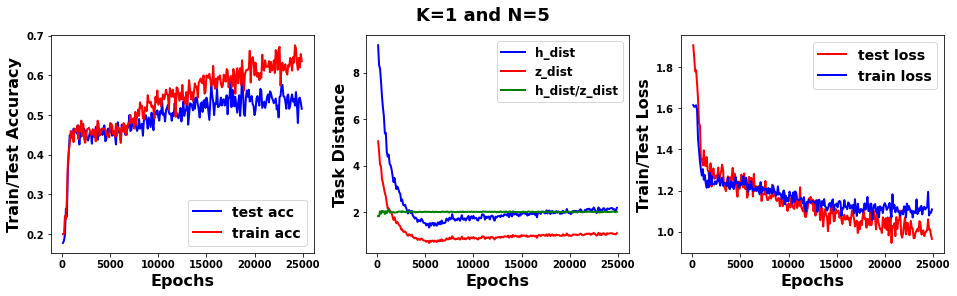

In [11]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots(1,3,figsize=(16,4))
val = -1
ax[0].plot(step_num[:val],test_acc[:val],linewidth=2,c='b',)
ax[0].plot(step_num[:val],train_acc[:val],linewidth=2,c='r',)
ax[1].plot(step_num[:val],h_dist[:val],linewidth=2,c='b',)
ax[1].plot(step_num[:val],z_dist[:val],linewidth=2,c='r',)
ax[1].plot(step_num[:val],np.asarray(h_dist[:val])/np.asarray(z_dist[:val]),linewidth=2,c='g',)
ax[2].plot(step_num[:val],train_loss[:val],linewidth=2,c='r')
ax[2].plot(step_num[:val],test_loss[:val],linewidth=2,c='b')
ax[2].legend(['test loss','train loss'],loc=1,prop={'size': 14})
ax[0].legend(['test acc','train acc'],loc=4,prop={'size': 14})
ax[1].legend(['h_dist','z_dist', 'h_dist/z_dist'],loc=1,prop={'size': 12})
ax[0].set_ylabel('Train/Test Accuracy',weight='bold',fontsize=16)
ax[1].set_ylabel('Task Distance',weight='bold',fontsize=16)
ax[2].set_ylabel('Train/Test Loss',weight='bold',fontsize=16)
ax[0].set_xlabel('Epochs',weight='bold',fontsize=16)
ax[1].set_xlabel('Epochs',weight='bold',fontsize=16)
ax[2].set_xlabel('Epochs',weight='bold',fontsize=16)

#ax[0].set_xlim(0,15000)
#ax[1].set_xlim(0,15000)
#ax[2].set_xlim(0,15000)
fig.suptitle('K=1 and N=5', fontsize=18,weight='bold')
plt.savefig('k_1_N-5_batch32-meta-reg-ratio-2.png',dpi=300)
plt.show()

In [12]:
np.save('step_num.npy',step_num)
np.save('train_loss.npy',train_loss)
np.save('test_loss.npy',test_loss)
np.save('test_acc.npy',test_acc)
np.save('train_acc.npy',train_acc)
model.save_weights('meta-reg-ratio-2')